In [1]:
import os
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from rDLSpp import IOfuncs as iof
from rDLSpp import RheoConfig as rconf
from rDLSpp import RheoCorr as rcorr
from rDLSpp import FTrheo as ft
from DSH import SharedFunctions as sf

This tutorial explains how to load and analyze oscillatory rheology experiments

In [5]:
froot = 'D:\\Data\\Chiara\\Test4'
rheo_protocol = rconf.RheoProtocol(froot, 'Config_Rheo.ini', 'expLog.txt')
list_names = rheo_protocol.GetFullFilenames()
rheo_explog = rheo_protocol.LoadExpLog(fheadersep=None, force_reload=True)
rheo_explog

,ID,Time,Type,Name,Strain,Period,Offset,RelOffset,Phase,Duration,StartTime,StartedOn,EndedOn,Active
0,1,0.946493,0,01_Test_DSS_000,0.0005,0.0628319,10,0,0,0.753982,0,0.015919,0.936798,1
1,1,1.89905,0,01_Test_DSS_001,0.0007339,0.0628319,10,0,0,0.753982,0,0.96802,1.88939,1
2,1,2.8374,0,01_Test_DSS_002,0.00107722,0.0628319,10,0,0,0.753982,0,1.92064,2.82808,1
3,1,3.78712,0,01_Test_DSS_003,0.00158114,0.0628319,10,0,0,0.753982,0,2.85981,3.77771,1
4,1,4.75754,0,01_Test_DSS_004,0.00232079,0.0628319,10,0,0,0.753982,0,3.81097,4.74781,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,1,1623.02,0,08_Test_DSS_004,3.71327,62.8319,10,0,0,753.982,0,868.736,1622.96,1
858,1,2377.34,0,08_Test_DSS_005,5.45034,62.8319,10,0,0,753.982,0,1623.03,2377.28,1
859,1,3131.63,0,08_Test_DSS_006,8,62.8319,10,0,0,753.982,0,2377.36,3131.58,1
860,1,3135.97,0,09_Test_OscillPos,1,1,10,0,0,4,0,3131.65,3135.92,1


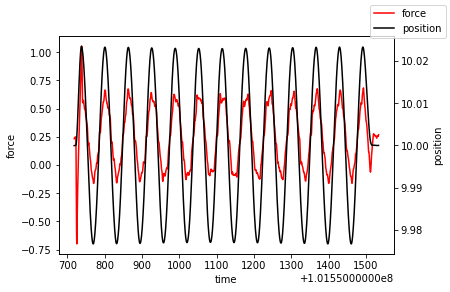

In [7]:
fidx = 10
int_time, int_pos, int_force = iof.ReadRheoData(list_names[fidx], usecols=(1, 2, 5), unpack=True)
if int_pos is not None:
    fig, ax = plt.subplots()
    ax.plot(int_time, int_force, 'r-', label='force')
    ax.set_xlabel('time')
    ax.set_ylabel('force')
    ax2 = ax.twinx()
    ax2.plot(int_time, int_pos, 'k-', label='position')
    ax2.set_ylabel('position')
    fig.legend()


The first and last periods involve acceleration and deceleration profiles. Let's disregard them:

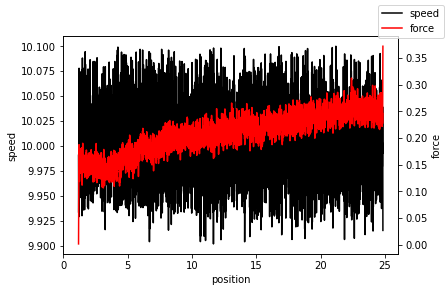

In [6]:
int_subset = np.where(np.abs(np.abs(int_speed)-float(rheo_explog.iloc[fidx]['Speed']))<0.1)
fig, ax = plt.subplots()
ax.plot(int_pos[int_subset], int_speed[int_subset], 'k-', label='speed')
ax.set_xlabel('position')
ax.set_ylabel('speed')
ax2 = ax.twinx()
ax2.plot(int_pos[int_subset], int_force[int_subset], 'r-', label='force')
ax2.set_ylabel('force')
fig.legend()

The force signal is not constant, it depends on the position. This is not real, it needs to be corrected. Two effects need to be taken into account in the force correction:
- The raw force signal is simply proportional to the current circulating in the voice coil, with a nominal constant conversion factor ($F_{max}=69N$ for the maximum imposed current).  In practice, the conversion factor, $f$, between current and force depends on the carriage position $x_{off}$: it is maximum when the magnet is in the middle of the coil, and decreases as the magnet moves towards the edges of the voice coil. We need a calibration of $f(x_{off})$, which comes typically from a high-frequency oscillatory test
- There is an offset-dependent static force, $F_s$, that depends probably on the air flow, and that simply adds to the total measured force. We need a calibration of $F_s(x_{off})$, which can come either from the same experiment used to calibrate $f(x_{off})$, or from a simpler experiment performed at constant, very slow speed.

Each calibration data set is in a separate, two-columns, tab-separated text file, and can be loaded using the ```RheoCorr``` module. In particular, the ```RheoCorr.LoadForceCalib()``` function reads the raw calibration data and fits it with either a spline or a polynomial to obtain a callable function

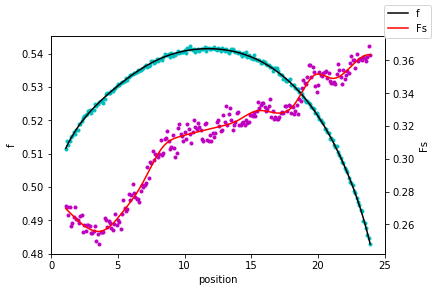

In [10]:
ForceCorrFunc, rawForceCorr = rcorr.LoadForceCalib(os.path.join('calibdata', 'foff.txt'), FitMethod='poly', FitParam=12, return_raw=True)
StaticForceFunc, rawStaticForce = rcorr.LoadForceCalib(os.path.join('calibdata', 'F0off.txt'), FitMethod='spline', FitParam=4e-3, return_raw=True)

fig, ax = plt.subplots()
ax.plot(*rawForceCorr, 'c.')
ax.plot(rawForceCorr[0], ForceCorrFunc(rawForceCorr[0]), 'k-', label='f')
ax.set_xlabel('position')
ax.set_ylabel('f')
ax2 = ax.twinx()
ax2.plot(*rawStaticForce, 'm.')
ax2.plot(rawStaticForce[0], StaticForceFunc(rawStaticForce[0]), 'r-', label='Fs')
ax2.set_ylabel('Fs')
fig.legend()

Force correction is taken care by the ```RheoCorr.ForceCorrection``` class, in particular through the ```RheoCorr.ForceCorrection.Correct(force, position, inplace=False)``` function

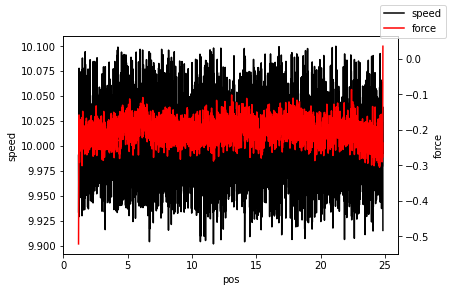

In [11]:
force_corr = rcorr.ForceCorrection(staticForce={'FilePath':os.path.join('calibdata', 'F0off.txt'), 'FitMethod':'spline', 'FitParam':4e-3},
                                    forceCurrent={'FilePath':os.path.join('calibdata', 'foff.txt'), 'FitMethod':'poly', 'FitParam':12})
int_force_corrected = force_corr.Correct(int_force, int_pos, inplace=False)
fig, ax = plt.subplots()
ax.plot(int_pos[int_subset], int_speed[int_subset], 'k-', label='speed')
ax.set_xlabel('pos')
ax.set_ylabel('speed')
ax2 = ax.twinx()
ax2.plot(int_pos[int_subset], int_force_corrected[int_subset], 'r-', label='force')
ax2.set_ylabel('force')
fig.legend()

We can also use one of the raw datasets directly coming from a rheology measurement for the static force correction:

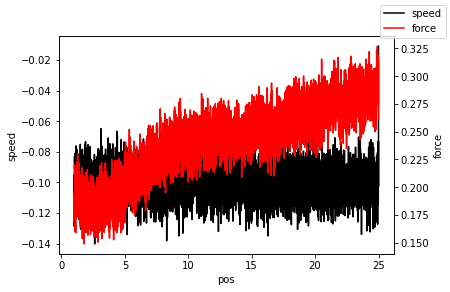

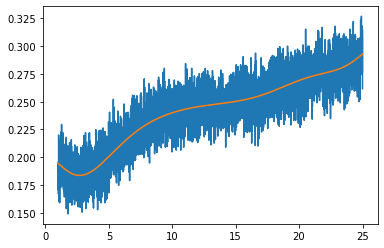

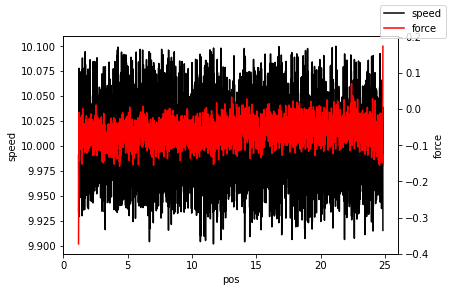

In [12]:
fidx_static = 35
int_time_stat, int_pos_stat, int_speed_stat, int_force_stat = iof.ReadRheoData(list_names[fidx_static], usecols=(1, 2, 3, 5), unpack=True)
if int_pos is not None:
    fig, ax = plt.subplots()
    ax.plot(int_pos_stat, int_speed_stat, 'k-', label='speed')
    ax.set_xlabel('pos')
    ax.set_ylabel('speed')
    ax2 = ax.twinx()
    ax2.plot(int_pos_stat, int_force_stat, 'r-', label='force')
    ax2.set_ylabel('force')
    fig.legend()

    StaticForceFunc_2, rawStaticForce_2 = rcorr.LoadForceCalib(list_names[fidx_static], FitMethod='poly', FitParam=10, return_raw=True, use_cols=(2,5))
    plt.figure()
    plt.plot(*rawStaticForce_2)
    plt.plot(rawStaticForce_2[0], StaticForceFunc_2(rawStaticForce_2[0]))

    force_corr.static_force = StaticForceFunc_2
    int_force_corrected_2 = force_corr.Correct(int_force, int_pos, inplace=False)
    fig, ax = plt.subplots()
    ax.plot(int_pos[int_subset], int_speed[int_subset], 'k-', label='speed')
    ax.set_xlabel('pos')
    ax.set_ylabel('speed')
    ax2 = ax.twinx()
    ax2.plot(int_pos[int_subset], int_force_corrected_2[int_subset], 'r-', label='force')
    ax2.set_ylabel('force')
    fig.legend()

Use this correction to get a flow curve:

Flowcurve computed and fitted with linear expressiong f=m*v+q with m = 8.31 kg/s and q = 6.40 mN


Text(0, 0.5, 'force [N]')

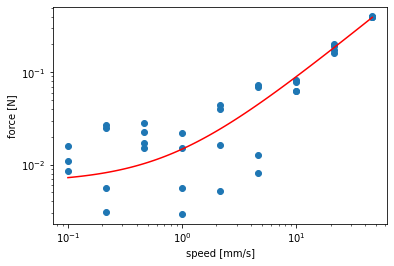

In [13]:
speed = []
avg_force = []
avg_posrange = [7.5, 17.5]
for i in range(rheo_protocol.CountIntervals(unpacked=True, check_explog=True)):
    if (i != fidx_static):
        cur_int_pos, cur_int_force = iof.ReadRheoData(list_names[i], usecols=(2, 5), unpack=True)
        cur_int_force_corr = force_corr.Correct(cur_int_force, cur_int_pos, inplace=False)
        speed.append(float(rheo_protocol.LoadExpLog().iloc[i]['Speed']))
        avg_force.append(np.mean(cur_int_force_corr[np.where(np.logical_and(cur_int_pos>=avg_posrange[0], cur_int_pos<=avg_posrange[1]))]))
m, q = np.polyfit(speed, np.abs(avg_force), 1)
print('Flowcurve computed and fitted with linear expressiong f=m*v+q with m = {0:.2f} kg/s and q = {1:.2f} mN'.format(m*1e3, q*1e3))

fig, ax = plt.subplots()
ax.plot(speed, np.abs(avg_force), 'o')
xarr = np.geomspace(np.min(speed), np.max(speed), 100)
ax.plot(xarr, m*xarr+q, 'r-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('speed [mm/s]')
ax.set_ylabel('force [N]')

In [ ]:
res_list = []
for i in range(len(res_fnames)):
    find_params = [p for p in exp_list if p[0]==res_fnames[i]]
    if len(find_params)==1:
        find_params = find_params[0]
        cur_F, cur_x, cur_k, cur_F0 = FTanalysisRheology(os.path.join(froot, res_fnames[i]), Period=find_params[2], AnalyzePeriods=tlen, FreqRecord=None, StaticForceCorr=StaticForceFunc, CurrentForceCorr=ForceCorrFunc, savefile_suf='_Fcorr')
        res_list.append([ord(find_params[0][-5]) - ord('a')] + find_params[1:] + [np.abs(cur_F), np.angle(cur_F), np.abs(cur_x), np.angle(cur_x), np.abs(cur_k), np.angle(cur_k), cur_F0])
    else:
        print('Error finding parameters for result ' + res_fnames[i])
        cur_F, cur_x, cur_k, cur_F0 = np.nan, np.nan, np.nan, np.nan
res_arr = np.asarray(res_list)
np.savetxt(os.path.join(froot, 'analysis_out_T' + str(tlen).zfill(2) + '_goodFcorr.dat'), res_arr, delimiter='\t', 
            header='run\tamplitude\tperiod\toffset\tF_abs\tF_phase\tx_abs\tx_phase\tk_abs\tk_phase\tF_avg')

NameError: name 'res_fnames' is not defined